In [1]:
# impoting necessary libraries
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from skimage.transform import resize
from skimage import img_as_float, img_as_ubyte
import cv2
import random
from skimage.util import montage

In [2]:
# setting matplotlib backend configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
CHILD_SIZE = 20 # the size of the child images in pixel that will be used as collage, childrens will be cropped to make it square
ALPHA = 0.7 # alpha value of the children
WEGHT = 0.5 # how much prominent the color filter should be, the more the value the more it is prominent

In [19]:
CHILD_SIZE = int(input("Give child size.\n(the size of the child images in pixel that will be used as collage, childrens will be cropped to make it square (ex: 20)"))
ALPHA = float(input("alpha value of the children between 0 and 1(ex: 0.7)"))
WEGHT = float(input("how much prominent the color filter should be, the more the value the more it is prominent between 0 and 1(ex: 0.5)"))

Give child size.
(the size of the child images in pixel that will be used as collage, childrens will be cropped to make it square (ex: 20)20
alpha value of the children between 0 and 1(ex: 0.7)0.7
how much prominent the color filter should be, the more the value the more it is prominent between 0 and 1(ex: 0.5)0.5


file name: ./master\Sherlock_Brett.jpg
master image height: 900 and width: 720


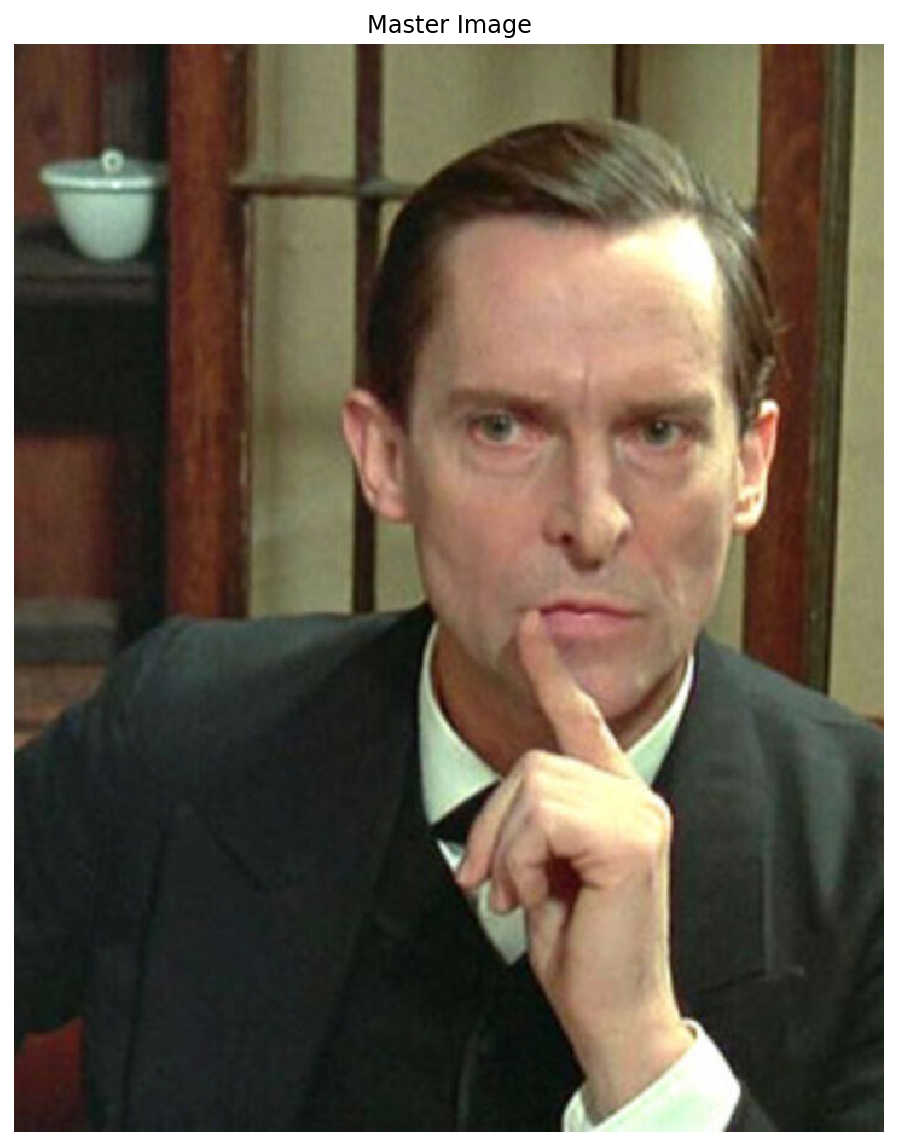

In [4]:
# importing master
master = None
master_images = io.ImageCollection(['./master/*.png','./master/*.jpg'])
print(f"file name: {master_images.files[0]}")

for images in master_images:
    master = img_as_float(images)
print(f"master image height: {master.shape[0]} and width: {master.shape[1]}")
_, axis = plt.subplots(1, 1, figsize=(10, 10))
axis.axis('off')
axis.set_title("Master Image")
axis.imshow(master)

In [5]:
# now we will determine the dominant colors of the master
master_height = master.shape[0]
master_width = master.shape[1]

h_bins = master_width // CHILD_SIZE + (1 if (master_width % CHILD_SIZE > 0) else 0)
v_bins = master_height // CHILD_SIZE + (1 if (master_height % CHILD_SIZE > 0) else 0)

print(f"total number of children can be stacked horizontally: {h_bins} and vertically: {v_bins}")

total number of children can be stacked horizontally: 36 and vertically: 45


In [6]:
dominant_colors = np.full((v_bins, h_bins, 3), 1.)

In [7]:
# method to get dominant color
def get_dominant_color(img):
    pixels = np.float32(img.reshape(-1, 3))

    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    dominant = palette[np.argmax(counts)]
    return dominant

In [8]:
def apply_color_filter(color, image):
    # create an image with a single color (here: red)
    color_img = np.full((image.shape[0], image.shape[1], 3),color, np.float64)

    # add the filter  with a weight factor of 20% to the target image
    filtered_img = cv2.addWeighted(image, (1 - WEGHT), color_img, WEGHT, 0)
    return img_as_float(filtered_img)

In [9]:
# importing child images and storing them
# child images should be nice square image for better result
children = []
child_images = io.ImageCollection(['./children/*.png','./children/*.jpg'])
print(f"number of children found : {len(child_images.files)}\n with {child_images.files[0]} ... {child_images.files[-1]}")

for child in child_images:
#     x_dim = child.shape[1]
#     y_dim = child.shape[0]
    #child = resize(child, (CHILD_SIZE, round((CHILD_SIZE/y_dim)*x_dim)), anti_aliasing=True)
    if(len(child.shape) == 3):
        # only process color image
        child = resize(child, (CHILD_SIZE, CHILD_SIZE))
        children.append(img_as_float(child))
    else:
        print("will not process GrayScale Image")

number of children found : 18
 with ./children\6d134c9abe4509707a547ab089b0b6ab.jpg ... ./children\the-adventures-of-sherlock-holmes-jeremy-brett-K351FM.jpg
will not process GrayScale Image


In [10]:
h_start = 0
v_start = 0

final_image = np.zeros((v_bins * CHILD_SIZE, h_bins * CHILD_SIZE, 3))
filtered_images = []

for row in range(v_bins):
    for col in range(h_bins):
        h_start = col * CHILD_SIZE
        v_start = row * CHILD_SIZE
        
        h = h_start
        hd = min((h_start + CHILD_SIZE), master_width)
        
        v = v_start
        vd = min((v_start + CHILD_SIZE), master_height)
        
        view = master[v:vd, h:hd]
        # finding dominant color
        dominant_color = get_dominant_color(view)
        dominant_colors[row, col] = dominant_color
        
        filtered_images.append(apply_color_filter(dominant_color, random.choice(children)))
        final_image[v:v+CHILD_SIZE, h:h+CHILD_SIZE] = apply_color_filter(dominant_color, random.choice(children))
        

In [11]:
# saving the image
io.imsave('./output/output_withput_background_alpha.png', img_as_ubyte(final_image))

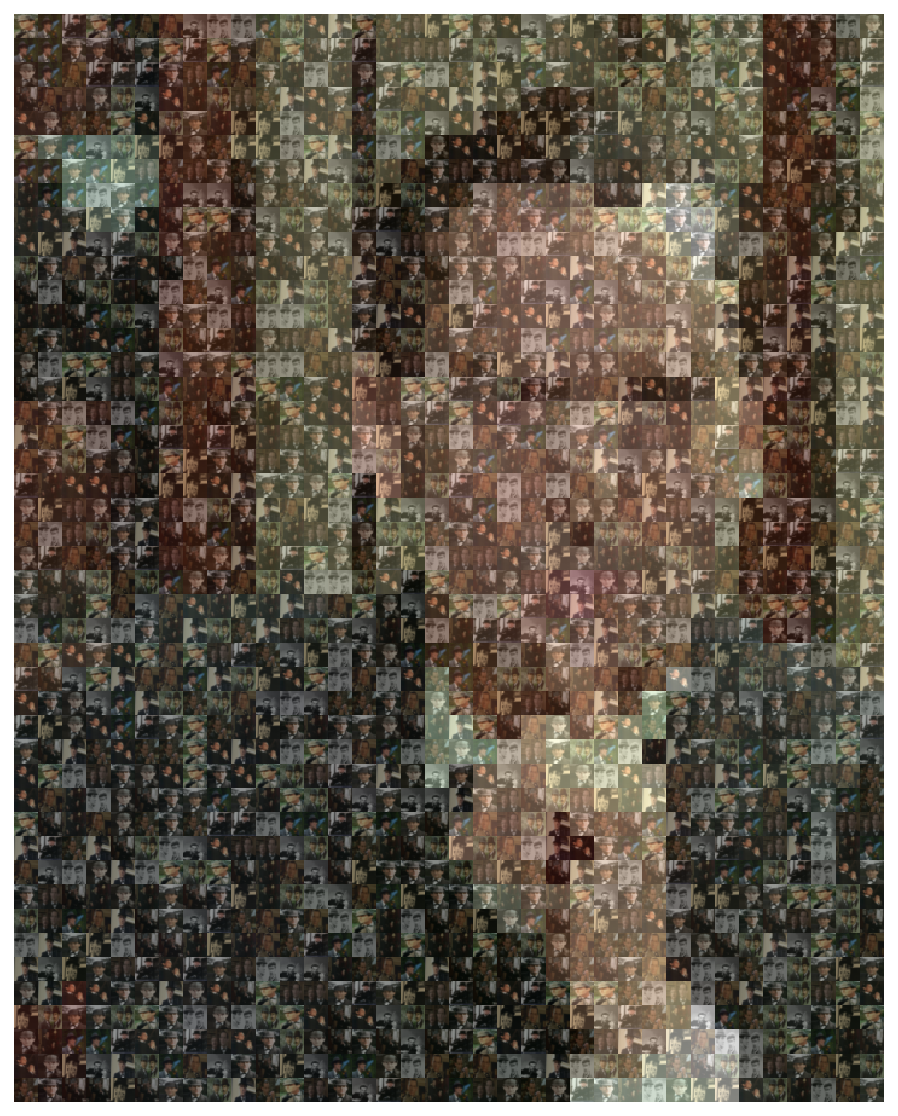

In [12]:
# generating image without alpha background
# plotting the image
_, axis = plt.subplots(1, 1, figsize=(10, 10))
axis.axis('off')
axis.imshow(final_image)

In [13]:
# generating image with alpha background
# final_image
# master

v_final_image = final_image.shape[0]
h_final_image = final_image.shape[1]

v_master = master.shape[0]
h_master = master.shape[1]

final_image = final_image[:v_master, :h_master]

final_image_with_alpha_background = (1-ALPHA) * master + ALPHA * final_image

In [14]:
# saving the image
io.imsave('./output/output_with_alpha.png', img_as_ubyte(final_image_with_alpha_background))

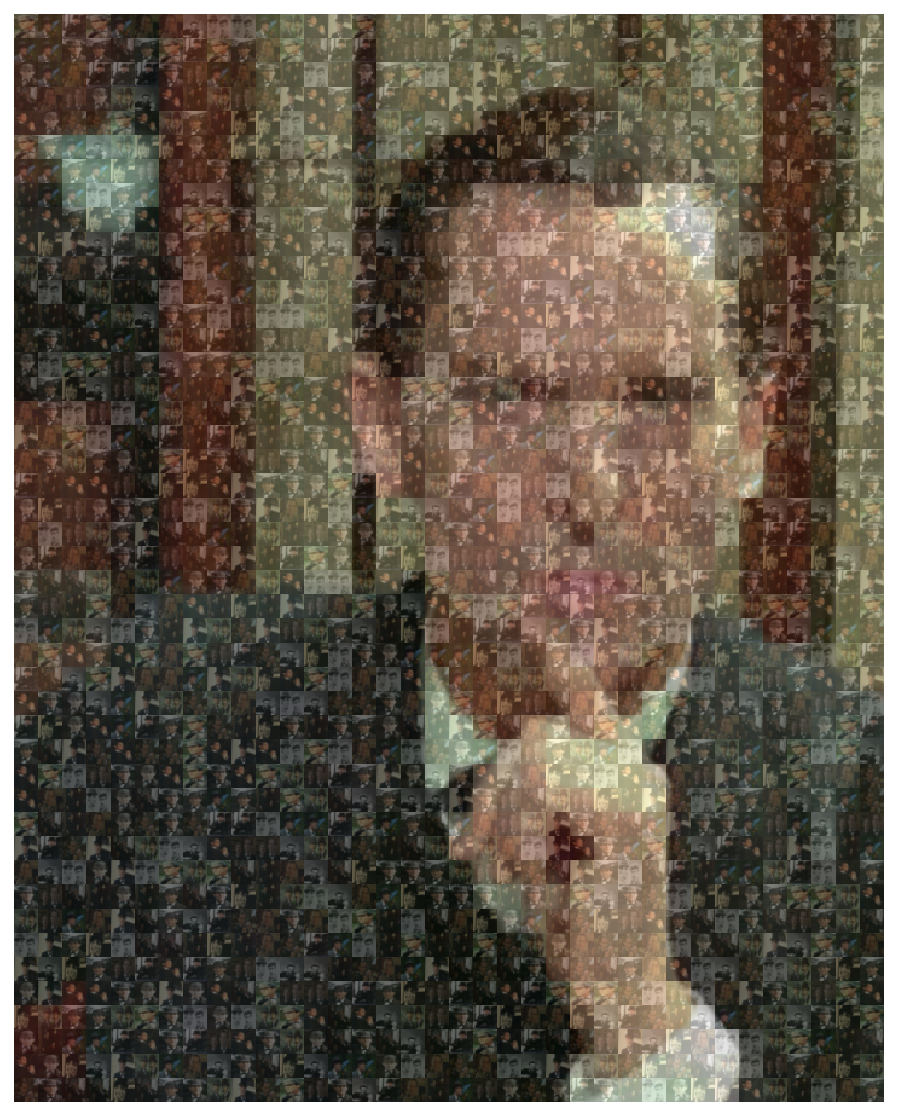

In [15]:
# plotting the image
_, axis = plt.subplots(1, 1, figsize=(10, 10))
axis.axis('off')
axis.imshow(final_image_with_alpha_background)

In [20]:
! pip freeze > requirements.txt